In [32]:
import pandas as pd
import pickle
import requests
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
from scipy.spatial.distance import cosine
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# from chembl_webresource_client.new_client import new_client
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Reshape, GRU, SpatialDropout1D, LSTM, Dropout
from keras.layers import BatchNormalization, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [7]:
df = pd.read_csv("../data/drug_class_identification/phase1/drugbank.csv")
df.shape
df.drop(df[df.smiles.isna()].index, inplace = True)
df.drop(df[df.atc.isna()].index, inplace = True)
df.drop(df[[False if len(smile)<250 else True for smile in df.smiles]].index, inplace = True)

In [8]:
df['atc1'] = [a[0] for a in df['atc']]

In [9]:
df.head()

,name,atc,inchi_key,smiles,atc1
13,goserelin,L02AE03,BLCLNMBMMGCOAS-URPVMXJPSA-N,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,L
33,desmopressin,H01BA02,NFLWUMRGJYTJIN-NXBWRCJVSA-N,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,H
47,cetrorelix,H01CC02,SBNPWPIBESPSIF-MHWMIDJBSA-N,CC(C)C[C@H](NC(=O)[C@@H](CCCNC(N)=O)NC(=O)[C@H...,H
84,ciclosporin,L04AD01,PMATZTZNYRCHOR-CGLBZJNRSA-N,CC[C@@H]1NC(=O)[C@H]([C@H](O)[C@H](C)C\C=C\C)N...,L
95,octreotide,H01CB02,DEQANNDTNATYII-OULOTJBUSA-N,[H][C@]1(NC(=O)[C@H](CCCCN)NC(=O)[C@@H](CC2=CN...,H


In [10]:
df.describe()

,name,atc,inchi_key,smiles,atc1
count,2737,2737,2737,2737,2737
unique,2737,2640,2737,2737,14
top,carbaspirin calcium,J01CR50,RONZAEMNMFQXRA-UHFFFAOYSA-N,S=[Se]=S,N
freq,1,22,1,1,469


In [11]:
df['smiles'] = [smile.ljust(250, '*') for smile in df['smiles']] 

### One Hot Encoding

In [12]:
vocabulary = set()
allSmiles = ""
for smile in df['smiles']:
    allSmiles+=smile
    for char in smile:
        vocabulary.add(char)
freq = Counter(allSmiles).most_common(25)

In [13]:
vocabulary = [a for a,b in freq]

In [14]:
'*' in vocabulary

True

In [15]:
oe = np.asarray(pd.get_dummies(np.asarray(vocabulary)))
oe_dict = {}
for a in range(len(vocabulary)):
    oe_dict[vocabulary[a]] = oe[a]

In [16]:
def encodeSmile(smile, oe):
    word = []
    for char in smile:
        try:
            temp = list(oe[char])
        except:
            temp = [0 for a in range(len(vocabulary))]
        word = word + temp
    return np.asarray(word, dtype=int)

In [17]:
X = []
X = [encodeSmile(smile, oe_dict) for smile in df['smiles']]

In [18]:
X = np.asarray(X)

In [19]:
ATCclasssubset = ['A', 'J', 'N', 'C']
num_classes = len(ATCclasssubset)

X_df = pd.DataFrame(X)
X_df['target'] = df['atc1']
X_df = X_df[X_df['target'].isin(ATCclasssubset)]
g = X_df.groupby('target')
X_df = g.apply(lambda x: x.sample(g.size().min())).reset_index(drop=True)

X = X_df[X_df.columns[:-1]]

### Prepare Data

In [20]:
y = pd.get_dummies(np.asarray(X_df['target']))                

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
temp = [[0 for b in range(0, num_classes)] for a in range(0, num_classes)]
for a in range(0, num_classes):
    temp[a][a] = 1
temp = np.asarray(temp)
atc_classes = y.columns

### Helper function

In [23]:
def accuracy(y_true, y_pred, atc_classes=atc_classes):
    print("Overall Accuracy:", np.sum(np.equal(y_true, y_pred))/y_true.shape[0])
    matrix = confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred))
    plt.figure(figsize=(10, 10))
    sns.heatmap(matrix,annot=True,cbar=False, xticklabels=atc_classes, yticklabels=atc_classes)

### Make the network

In [24]:
class Network:
    def __init__(self, num_classes):
        self.model = Sequential()
        self.model.add(Reshape((250, 25), input_shape=(6250, )))
        self.model.add(Conv1D(192, 5, activation='relu', input_shape=(250, 25)))
        self.model.add(MaxPool1D(5))
        self.model.add(BatchNormalization())        
        self.model.add(Conv1D(192, 5, activation='relu'))
        self.model.add(MaxPool1D(5))
        self.model.add(Conv1D(140, 3, activation='relu'))
#         self.model.add(LSTM(70, dropout=0.7, recurrent_dropout=0.2, activation='selu', return_sequences=True,))
#         self.model.add(LSTM(70, dropout=0.4, recurrent_dropout=0.2, activation='relu'))
        self.model.add(Flatten())
        self.model.add(Dense(100, activation='relu'))
        self.model.add(Dropout(rate=0.4))
        self.model.add(Dense(num_classes, activation='softmax'))
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        print(self.model.summary())
        
    def train(self, X, y, X_test, y_test, epochs=20):
        self.model.fit(X, y, epochs=epochs, validation_data=(X_test, y_test))
    
    def test(self, X, y):
        y_pred = self.model.predict(X).argmax(axis=1)
        y_true = y.argmax(axis=1)
        accuracy(y_true, y_pred)
        

In [27]:
network = Network(4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 250, 25)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 246, 192)          24192     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 49, 192)           0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 49, 192)           768       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 45, 192)           184512    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 9, 192)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 7, 140)            80780     
__________

In [30]:
network.train(X_train, y_train, X_test, y_test, epochs=20)

Train on 338 samples, validate on 146 samples
Epoch 1/20
338/338 [==============================] - 1s 3ms/step - loss: 0.4191 - acc: 0.8550 - val_loss: 1.7473 - val_acc: 0.2603
Epoch 2/20
338/338 [==============================] - 1s 3ms/step - loss: 0.2598 - acc: 0.9260 - val_loss: 1.8758 - val_acc: 0.3082
Epoch 3/20
338/338 [==============================] - 1s 3ms/step - loss: 0.1678 - acc: 0.9556 - val_loss: 2.3077 - val_acc: 0.2808
Epoch 4/20
338/338 [==============================] - 1s 3ms/step - loss: 0.1797 - acc: 0.9467 - val_loss: 2.3589 - val_acc: 0.2466
Epoch 5/20
338/338 [==============================] - 1s 3ms/step - loss: 0.1021 - acc: 0.9852 - val_loss: 2.4394 - val_acc: 0.2329
Epoch 6/20
338/338 [==============================] - 1s 3ms/step - loss: 0.0579 - acc: 0.9882 - val_loss: 2.5033 - val_acc: 0.2603
Epoch 7/20
338/338 [==============================] - 1s 3ms/step - loss: 0.0346 - acc: 1.0000 - val_loss: 2.6246 - val_acc: 0.2329
Epoch 8/20
338/338 [==========

In [29]:
s = network.test(X_test, y_test)

AttributeError: 'DataFrame' object has no attribute 'argmax'

In [293]:
y_test

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],


In [43]:
oeAtc = pd.get_dummies(np.asarray(X_df['target']))

In [44]:
oeAtc

,A,C,J,N
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
479,0,0,0,1
480,0,0,0,1
481,0,0,0,1
482,0,0,0,1


In [45]:
oe

,#,(,),*,+,-,.,/,1,2,...,F,H,I,N,O,S,[,\,],l
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
l = [( 0.2278 ,0.2534),
( 0.2811 ,0.2603),
( 0.2959 ,0.2534),
( 0.3787 ,0.2260),
( 0.4083 ,0.2534),
( 0.4615 ,0.3014),
( 0.5266 ,0.2603),
( 0.6391 ,0.2808),
( 0.7544 ,0.2534),
( 0.8284 ,0.1918),
( 0.8550 ,0.2603),
( 0.9260 ,0.3082),
( 0.9556 ,0.2808),
( 0.9467 ,0.2466),
( 0.9852 ,0.2329),
( 0.9882 ,0.2603),
( 1.0000 ,0.2329),
( 0.9970 ,0.2534),
( 1.0000 ,0.2466),
( 1.0000 ,0.2260)]

In [58]:
plt.figure(figsize=(20, 6))
plt.plot([a for a in range(1, 21)], [a[0] for a in l], label="training accuracy")
plt.plot([a for a in range(1, 21)], [a[1] for a in l], label="validation accuracy")
plt.xticks([a for a in range(1, 21)])
plt.yticks([a/10 for a in range(0, 11)])
plt.legend()

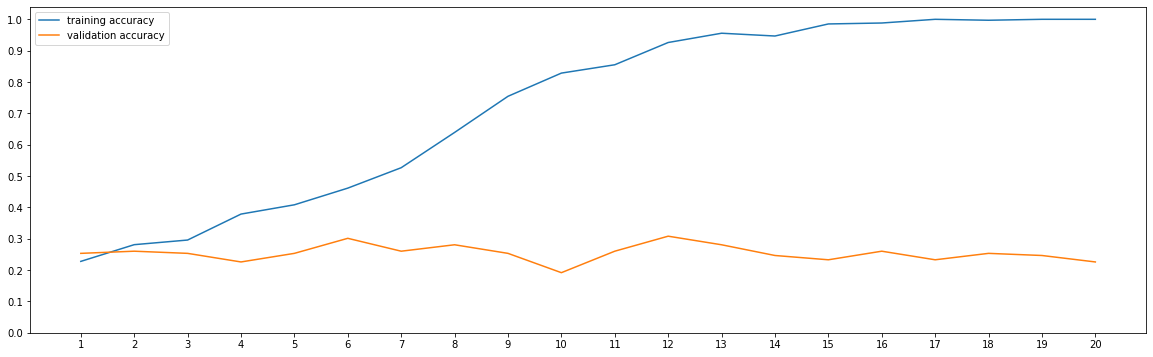

In [59]:
plt.show()